In [28]:
#The goal of this assignment is to creat a prediction model on the priority variables
# My assigned responce variable is PG5_5PHR
#The data is 1353 samples/observations and 82 different feature columns.



##### Reading in the data #######
# For nicer printing
options(digits=2);
data <- read.csv("TechSurvey - Survey.csv",header=T);
#convert date to unix second
for (i in c("Start", "End"))
  data[,i] = as.numeric(as.POSIXct(strptime(data[,i], "%Y-%m-%d %H:%M:%S")))

for (i in 0:12){
  vnam = paste(c("PG",i,"Submit"), collapse="")
  data[,vnam] = as.numeric(as.POSIXct(strptime(data[,vnam], "%Y-%m-%d %H:%M:%S")))
}
#calculate differences in time
for (i in 12:0){
  pv = paste(c("PG",i-1,"Submit"), collapse="");
  if (i==0)
    pv="Start";
  vnam = paste(c("PG",i,"Submit"), collapse="");
  data[,vnam] = data[,vnam] -data[,pv];
}

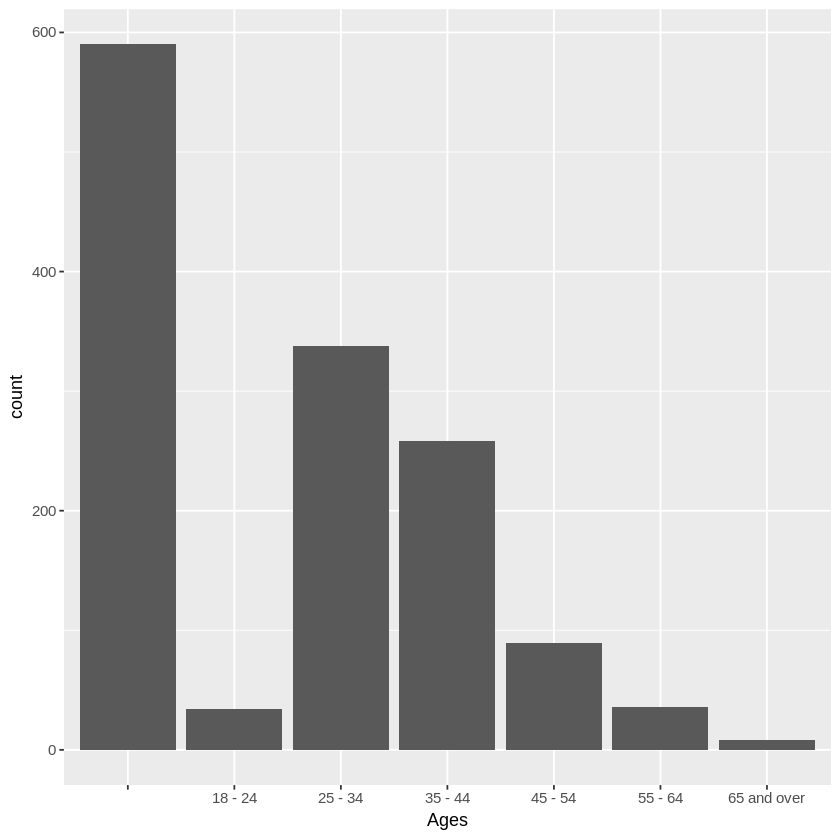

In [29]:
####### The simple questions are ##########
# 1. Time to take entire survey? In order to get that, I get the average time for all of the observcations which is 680 seconds. (total = 680)
      total = mean(data$End - data$Start, na.rm = TRUE)
      
# 2. Question that took the longest to complete?
      submit_times <- data[, grep("Submit", colnames(data), value = TRUE)]
      #extract page 0
      submit_times = submit_times[, -c(1)]
      #average time of each question 
      submit_means = apply(submit_times, 2, mean, na.rm = TRUE)
      longest = names(submit_means[which(submit_means == max(submit_means))])
      #longest = PG5Submit which is reasonable because this is the hardet and most generic question in the survey
      
# 3. Question that took the least time?
      shortest = names(submit_means[which(submit_means == min(submit_means))])
      #shortest = PG11Submit which is asking the gender and is very easy to answer!
      
# 4. Top-ranked criteria?
      ranked = data[, grep("PG5", colnames(data), value = TRUE)]
      ordered = ranked[, grep("Order", colnames(ranked), value = TRUE)]
      means = apply(ordered, 2, mean, na.rm = TRUE)
      top_ranked = names(means[which(means == max(means))])
      #top_ranked = PG5_2Order which is 
      
# 5. Demographic distribution by age?
      library(ggplot2)
      Ages = data[,81]
      ggplot(data.frame(data[,81]), aes(x=Ages)) + geom_bar()
      #As the plot shows from the people who have answered this question the majority of the are within the range of 25-34


# Hypothesis:
I think the priority is going to be effected by the experince of the programmer.
For example if the programmer is a software developer they might care
more about the reputation of the package that they are using. I would also hink that
it might be effected by the level of experince and the languages that they use.

## Explanation how needed measures are calculated from the provided data
In order to be able to to a modeling on the data I need to extract the columns that are related to my responce variable. Doing some statistic such as corrolation I can find the highly correlated variables and exclude them from my model. As for the model, I use RandomForest and AUC to check the accuracy of the model. In order to know what variables are important I used the "importance" function in R.
## descriptive analysis of the proposed measures
The following code and the comments describes this. 
## transformation and cleaning statement
I needed to clean the data by removing the columns with too many unique variables but not too man observations for each. In addition removing highly correlated variables plus the un necessory variable for PG4. 

In [30]:
# Explanation how needed measures are calculated from the provided data
# descriptive analysis of the proposed measures
# transformation and cleaning statement
      
  # The following is how I extract the columns that are related to my responce variable
  # Not all of the extracted valuses are going to be used in the model though.

  # My responce variable is PG5_5PHR = data[,'PG5_5PHR']
  # remove all other variables in page 5 other than mine
      
  #fixing the name of the responce column for the 3rd question
  colnames(data)[grep("PG2Resp.1", colnames(data))] = "PG3Resp"
  #find the title of the columns
  col_names = colnames(data)
  #Find the index of columns that are in page 5
  col5_ind = c(grep("PG5", col_names))
  #Find the index of my resmonce variable 
  mine = c(grep("PG5_5PHR", col_names))
  #remove the index of my responce variable from the list of the columns that are going to be deleted
  col5_ind = col5_ind[-grep(mine, col5_ind)]
  
  #times_ind = match(c("End", "Start"), col_names)
  #times_ind= c(times_ind, grep("Submit", col_names))
  #ind = c (col5_ind, times_ind)
  
  ###Removing columns related to page 4 that I don't need.
  col4_ind = match(c("PG4Dtr0_6", "PG4Psv7_8", "PG4Prm9_10"), colnames(data))
  colOther_ind = match(c("PG7Other", "PG1Other"), colnames(data)) #remove the "other" columns
  lotsUniq_ind = match(c("PG3Resp", "PG8Resp"), colnames(data)) #remove variable with too many uniquw values
  
  ind = c(col4_ind, col5_ind, colOther_ind,lotsUniq_ind)
  
  model_data = data[,-ind]

  
  model_data<- model_data[,c(1:16,18:ncol(model_data), 17)]
  
  ## those observation that are epmty need to be removes
  model_data<- model_data[-c(which(model_data[,"PG5_5PHR"]=="")),]
  
  summary(model_data)
  


     Device    Completed       Start               End               PG0Dis   
        :  0   0    :  0   Min.   :1.54e+09   Min.   :1.54e+09   Min.   :  0  
 Bot    :  0   FALSE:  8   1st Qu.:1.54e+09   1st Qu.:1.54e+09   1st Qu.:  0  
 PC     :462   TRUE :592   Median :1.54e+09   Median :1.54e+09   Median :  1  
 Phone  :128               Mean   :1.54e+09   Mean   :1.54e+09   Mean   : 46  
 Tablet : 10               3rd Qu.:1.54e+09   3rd Qu.:1.54e+09   3rd Qu.: 24  
 Unknown:  0               Max.   :1.54e+09   Max.   :1.54e+09   Max.   :168  
                                              NA's   :8          NA's   :36   
    PG0Shown      PG0Submit    
 Min.   :   0   Min.   :    2  
 1st Qu.:   0   1st Qu.:    6  
 Median : 119   Median :    9  
 Mean   : 268   Mean   :  218  
 3rd Qu.: 471   3rd Qu.:   15  
 Max.   :1190   Max.   :76226  
 NA's   :36                    
                                       PG1PsnUse  
 For personal work and/or research use      :418  
          

In [31]:
 # correlation analysis and a statement about whhether or not some of the measures are too correlated and need to be dropped
  #get numeric fields only for correlation
  sel = c()
  for (i in 1:dim(model_data)[2]) if (is.numeric(model_data[,i])) sel = c(sel, i);
  correlation <- cor(model_data[,sel],method="spearman",use="pairwise.complete.obs"); #OK for any: uses ranks
  hight_cor <- which(abs(correlation) > 0.7 & abs(correlation) < 0.999999, arr.ind = TRUE)
  hight_cor
  rownames(hight_cor) #= "End"      "Start"    "PG0Shown" "PG0Dis"
  ## remove the highly correlated columns from model_data
  model_data <- model_data[,-c( match(rownames(hight_cor), colnames(model_data)))]

,row,col
End,2,1
Start,1,2
PG0Shown,4,3
PG0Dis,3,4


[1] "End"      "Start"    "PG0Shown" "PG0Dis"

In [32]:
  library(rpart)
  library(AUC)
  library(randomForest)

## Model data:

In [33]:
  model_data$PG5_5PHR<- as.factor(as.character(model_data$PG5_5PHR))
  
  #fitting of the statistical model
  #Now the data is ready and I need to split the data into train and test
  train_ind = sample(1:nrow(model_data), nrow(model_data)*0.75)
  train_data = model_data[train_ind,]
  test_data = model_data[-c(train_ind),]
  
  train = train_data[, -c(ncol(train_data))]
  train_y = train_data[, ncol(train_data)]
  # library(magrittr)
  # train = train %>% select(-PG3Resp, -PG8Resp, -PG7, -PG1)
  
  
  test = test_data[, -c(ncol(test_data))]
  test_y = test_data[, ncol(test_data)]

[1] 0.47

,MeanDecreaseAccuracy
Device,-0.257
Completed,0.000
PG0Submit,1.575
PG1PsnUse,-0.886
PG1WdAuth,0.475
PG1Trn,-1.550
PG1Submit,-0.304
PG2Resp,-1.114
PG2Submit,-0.759
PG3Submit,-0.680


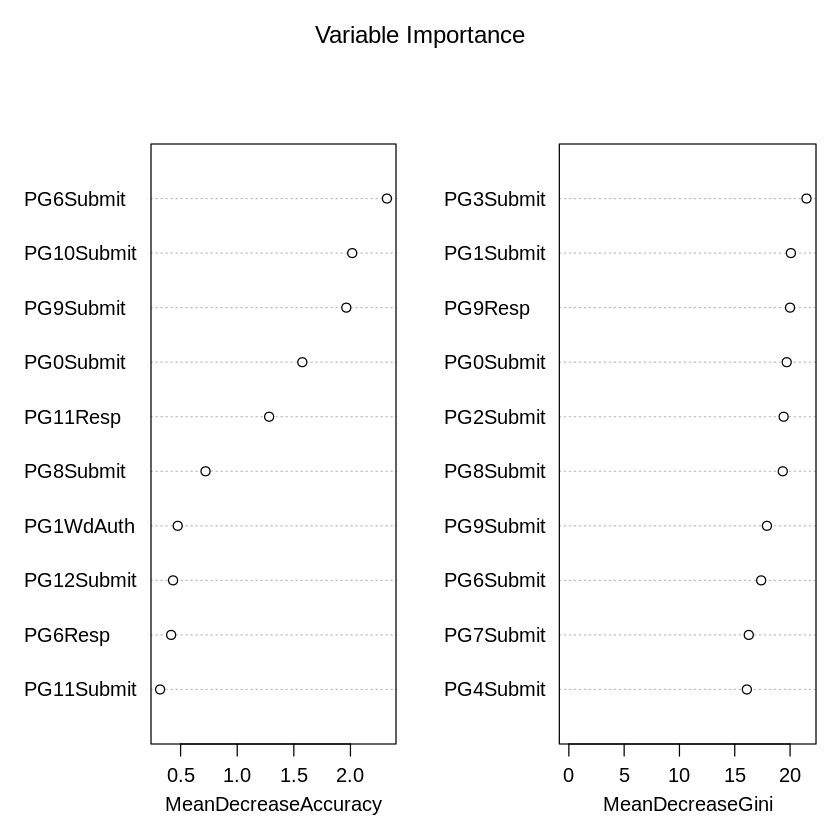

In [34]:
  rf<- randomForest(PG5_5PHR ~ . , data=train_data, na.action = na.omit, iter = 100, ntree = 100, importance=TRUE)
  pred<- predict(rf, test_data)
  AUC::auc(roc(pred,test_y))
  varImpPlot(rf, n.var = 10, main = "Variable Importance")
  importance(rf, type = 1)

According to the current model, submit time is one of the important variabls. 
## Let's remove the submit columns

In [37]:
str(test_data)
str(train_data)

'data.frame':	150 obs. of  20 variables:
 $ Device       : Factor w/ 6 levels "","Bot","PC",..: 3 3 4 4 4 3 3 3 3 3 ...
 $ Completed    : Factor w/ 3 levels "0","FALSE","TRUE": 3 3 3 3 3 3 3 3 3 3 ...
 $ PG1PsnUse    : Factor w/ 15 levels "","Chapter book",..: 3 3 3 3 1 3 3 3 1 3 ...
 $ PG1WdAuth    : Factor w/ 5 levels "","Because Microsoft was paying me to do it",..: 1 1 1 1 1 1 3 1 1 1 ...
 $ PG1Trn       : Factor w/ 3 levels "","For a training / class that I took",..: 1 2 1 1 2 1 1 1 1 1 ...
 $ PG2Resp      : Factor w/ 4 levels "","No","Not sure",..: 4 2 2 3 3 3 2 3 4 4 ...
 $ PG4AllResp   : int  8 8 7 8 5 NA 9 9 10 10 ...
 $ PG6Resp      : Factor w/ 7 levels "","13 - 19 years",..: 2 7 3 3 7 3 5 3 7 3 ...
 $ PG7R         : Factor w/ 33 levels "","Bash, batch",..: 16 16 16 16 16 16 16 16 16 15 ...
 $ PG7C.C..     : Factor w/ 3 levels "","C/C++","Cobol": 1 2 1 1 1 1 1 2 1 1 ...
 $ PG7Java      : Factor w/ 3 levels "","Java","scala": 1 1 1 1 1 1 1 1 1 1 ...
 $ PG7Python    : Factor w/

In [36]:
test_data <- test_data[, -(grep("Submit", colnames(test_data)))]
train_data <- train_data[, -(grep("Submit", colnames(train_data)))]

[1] 0.43

,MeanDecreaseAccuracy
Device,0.79658
Completed,0.23800
PG1PsnUse,1.11457
PG1WdAuth,2.37005
PG1Trn,-0.87285
PG2Resp,0.00048
PG4AllResp,-0.44630
PG6Resp,0.77729
PG7R,0.11063
PG7C.C..,-0.54879


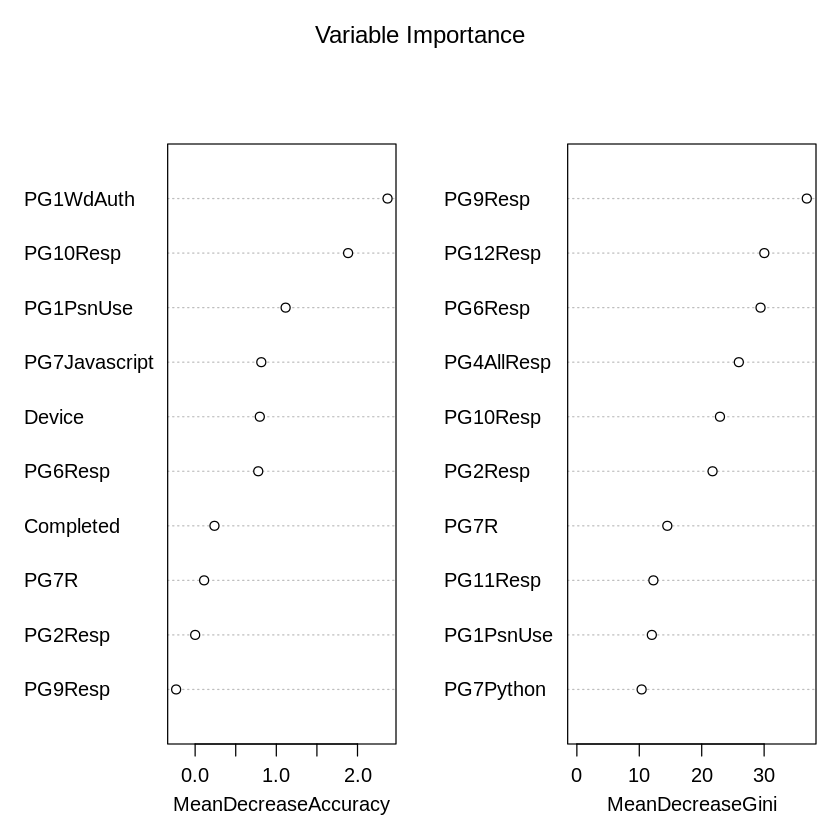

In [44]:
rf<- randomForest(PG5_5PHR ~ . , data=train_data, na.action = na.omit, iter = 100, ntree = 100, importance=TRUE)
pred<- predict(rf, test_data)
AUC::auc(roc(pred,test_y))  
varImpPlot(rf, n.var = 10, main = "Variable Importance")
importance(rf, type = 1)

The result somehow confirms my hypothesis but not completely(PG7Javascript).  We can see that the project purpose variable is a more important factor.